# NB 05: Cross-Organism Module Alignment

Group modules from different organisms into conserved "module families"
using ortholog fingerprints.

Steps:
1. Extract BBH pairs from `ortholog` table
2. Build ortholog groups (OGs) via connected components
3. Convert each module → OG fingerprint
4. Cluster into module families by cosine similarity
5. Consensus annotations for families

**Part 1 (JupyterHub)**: Extract ortholog pairs.
**Part 2 (local)**: Build OGs and align modules.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

DATA_DIR = Path('../data')
MODULE_DIR = DATA_DIR / 'modules'
ORTHO_DIR = DATA_DIR / 'orthologs'
FAMILY_DIR = DATA_DIR / 'module_families'
ORTHO_DIR.mkdir(parents=True, exist_ok=True)
FAMILY_DIR.mkdir(parents=True, exist_ok=True)

pilots = pd.read_csv(DATA_DIR / 'pilot_organisms.csv')
pilot_ids = pilots['orgId'].tolist()
print(f"Pilot organisms: {pilot_ids}")

Pilot organisms: ['DvH', 'Btheta', 'Methanococcus_S2', 'psRCH2', 'Putida', 'Phaeo', 'Marino', 'pseudo3_N2E3', 'Koxy', 'Cola', 'WCS417', 'Caulo', 'SB2B', 'pseudo6_N2E2', 'Dino', 'pseudo5_N2C3_1', 'Miya', 'Pedo557', 'MR1', 'Keio', 'Korea', 'PV4', 'pseudo1_N1B4', 'acidovorax_3H11', 'SynE', 'Methanococcus_JJ', 'BFirm', 'Kang', 'ANA3', 'Cup4G11', 'pseudo13_GW456_L13', 'Ponti']


## Part 1: Extract BBH Ortholog Pairs (Spark)

In [2]:
bbh_file = ORTHO_DIR / 'pilot_bbh_pairs.csv'

try:
    spark = get_spark_session()
    HAS_SPARK = True
    print(f"Spark version: {spark.version}")
except Exception:
    HAS_SPARK = False
    print("No Spark — using cached data")

if HAS_SPARK and not (bbh_file.exists() and bbh_file.stat().st_size > 0):
    # Build SQL filter for pilot organisms
    org_list = ", ".join([f"'{o}'" for o in pilot_ids])
    
    bbh = spark.sql(f"""
        SELECT orgId1, locusId1, orgId2, locusId2,
               CAST(ratio AS FLOAT) as ratio
        FROM kescience_fitnessbrowser.ortholog
        WHERE orgId1 IN ({org_list})
          AND orgId2 IN ({org_list})
    """).toPandas()
    bbh.to_csv(bbh_file, index=False)
    print(f"Extracted {len(bbh)} BBH pairs among pilot organisms")
else:
    bbh = pd.read_csv(bbh_file)
    print(f"Loaded {len(bbh)} cached BBH pairs")

Spark version: 4.0.1


Loaded 1148966 cached BBH pairs


## Part 2: Build Ortholog Groups

In [3]:
og_file = ORTHO_DIR / 'ortholog_groups.csv'

if og_file.exists() and og_file.stat().st_size > 0:
    og_df = pd.read_csv(og_file)
    print(f"CACHED: {og_df['OG_id'].nunique()} ortholog groups")
else:
    # Build graph: nodes = (orgId, locusId), edges = BBH pairs
    G = nx.Graph()
    for _, row in bbh.iterrows():
        n1 = f"{row['orgId1']}:{row['locusId1']}"
        n2 = f"{row['orgId2']}:{row['locusId2']}"
        G.add_edge(n1, n2, weight=row['ratio'])
    
    print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Connected components = ortholog groups
    components = list(nx.connected_components(G))
    print(f"Ortholog groups: {len(components)}")
    
    og_records = []
    for og_id, comp in enumerate(components):
        for node in comp:
            org, locus = node.split(':', 1)
            og_records.append({'OG_id': f'OG{og_id:05d}', 'orgId': org, 'locusId': locus})
    
    og_df = pd.DataFrame(og_records)
    og_df.to_csv(og_file, index=False)
    print(f"Saved {len(og_df)} gene-OG assignments ({og_df['OG_id'].nunique()} OGs)")

# Summary
og_sizes = og_df.groupby('OG_id').size()
og_org_count = og_df.groupby('OG_id')['orgId'].nunique()
print(f"\nOG size: median={og_sizes.median():.0f}, max={og_sizes.max()}")
print(f"OGs spanning 2+ organisms: {(og_org_count >= 2).sum()}")
print(f"OGs spanning all {len(pilot_ids)} pilots: {(og_org_count >= len(pilot_ids)).sum()}")

CACHED: 13402 ortholog groups

OG size: median=3, max=1189
OGs spanning 2+ organisms: 13402
OGs spanning all 32 pilots: 108


## 3. Module → OG Fingerprints

In [4]:
# Get all OG IDs for fingerprint vector
all_ogs = sorted(og_df['OG_id'].unique())
og_to_idx = {og: i for i, og in enumerate(all_ogs)}
n_ogs = len(all_ogs)
print(f"Fingerprint dimensionality: {n_ogs} OGs")

# Build gene→OG lookup per organism
gene_to_og = {}
for _, row in og_df.iterrows():
    key = (row['orgId'], str(row['locusId']))
    gene_to_og[key] = row['OG_id']

# Build fingerprints for all modules across all organisms
module_fingerprints = []
module_labels = []

for org_id in pilot_ids:
    weights_file = MODULE_DIR / f'{org_id}_gene_weights.csv'
    member_file = MODULE_DIR / f'{org_id}_gene_membership.csv'
    
    if not member_file.exists():
        print(f"Skipping {org_id} — no modules")
        continue
    
    weights = pd.read_csv(weights_file, index_col=0)
    membership = pd.read_csv(member_file, index_col=0)
    
    for mod in membership.columns:
        mod_genes = membership.index[membership[mod] == 1].astype(str)
        if len(mod_genes) == 0:
            continue
        
        # Build OG fingerprint weighted by |gene_weight|
        fingerprint = np.zeros(n_ogs)
        for gene in mod_genes:
            og = gene_to_og.get((org_id, gene))
            if og and og in og_to_idx:
                w = abs(weights.loc[weights.index.astype(str) == gene, mod].values[0])
                fingerprint[og_to_idx[og]] += w
        
        if fingerprint.sum() > 0:
            module_fingerprints.append(fingerprint)
            module_labels.append({'orgId': org_id, 'module': mod})

fp_matrix = np.array(module_fingerprints)
label_df = pd.DataFrame(module_labels)
print(f"\nFingerprint matrix: {fp_matrix.shape[0]} modules × {fp_matrix.shape[1]} OGs")
print(f"Non-zero entries: {(fp_matrix > 0).sum()} / {fp_matrix.size} ({(fp_matrix > 0).mean()*100:.1f}%)")

Fingerprint dimensionality: 13402 OGs



Fingerprint matrix: 1114 modules × 13402 OGs
Non-zero entries: 28043 / 14929828 (0.2%)


## 4. Cluster into Module Families

In [5]:
# Cosine similarity between modules from DIFFERENT organisms only
cos_sim = cosine_similarity(fp_matrix)

# Mask within-organism similarities (set to 0)
for i in range(len(label_df)):
    for j in range(len(label_df)):
        if label_df.iloc[i]['orgId'] == label_df.iloc[j]['orgId']:
            cos_sim[i, j] = 0 if i != j else 1

# Hierarchical clustering on cosine distance
cos_dist = 1 - np.abs(cos_sim)
np.fill_diagonal(cos_dist, 0)
cos_dist = np.clip(cos_dist, 0, 1)  # numerical safety

condensed = squareform(cos_dist)
Z = linkage(condensed, method='average')

# Cut at distance threshold to define families
family_labels = fcluster(Z, t=0.7, criterion='distance')
label_df['familyId'] = [f'F{f:03d}' for f in family_labels]

# Keep only families spanning 2+ organisms
family_org_count = label_df.groupby('familyId')['orgId'].nunique()
multi_org_families = family_org_count[family_org_count >= 2].index
print(f"Total families: {label_df['familyId'].nunique()}")
print(f"Families spanning 2+ organisms: {len(multi_org_families)}")

label_df.to_csv(FAMILY_DIR / 'module_families.csv', index=False)
print(f"Saved: module_families.csv")

Total families: 749
Families spanning 2+ organisms: 156
Saved: module_families.csv


## 5. Consensus Annotations for Families

In [6]:
# For each multi-organism family, collect module annotations and find consensus
family_annotations = []

for fam_id in multi_org_families:
    fam_modules = label_df[label_df['familyId'] == fam_id]
    
    # Collect all significant enrichments from member modules
    all_terms = []
    for _, row in fam_modules.iterrows():
        ann_file = MODULE_DIR / f"{row['orgId']}_module_annotations.csv"
        if not ann_file.exists() or ann_file.stat().st_size < 10:
            continue
        ann = pd.read_csv(ann_file)
        if len(ann) == 0:
            continue
        mod_ann = ann[(ann['module'] == row['module']) & (ann['significant'] == True)]
        for _, a in mod_ann.iterrows():
            all_terms.append({
                'term': a['term'],
                'database': a['database'],
                'orgId': row['orgId'],
                'fdr': a['fdr']
            })
    
    if not all_terms:
        family_annotations.append({
            'familyId': fam_id,
            'n_organisms': len(fam_modules['orgId'].unique()),
            'n_modules': len(fam_modules),
            'consensus_term': 'unannotated',
            'consensus_db': '',
            'term_organisms': 0,
            'mean_fdr': 1.0
        })
        continue
    
    terms_df = pd.DataFrame(all_terms)
    
    # Consensus: term appearing in most organisms with best mean FDR
    term_stats = terms_df.groupby(['term', 'database']).agg(
        term_organisms=('orgId', 'nunique'),
        mean_fdr=('fdr', 'mean')
    ).reset_index()
    term_stats = term_stats.sort_values(['term_organisms', 'mean_fdr'],
                                        ascending=[False, True])
    best = term_stats.iloc[0]
    
    family_annotations.append({
        'familyId': fam_id,
        'n_organisms': len(fam_modules['orgId'].unique()),
        'n_modules': len(fam_modules),
        'consensus_term': best['term'],
        'consensus_db': best['database'],
        'term_organisms': int(best['term_organisms']),
        'mean_fdr': best['mean_fdr']
    })

fam_ann_df = pd.DataFrame(family_annotations)
fam_ann_df.to_csv(FAMILY_DIR / 'family_annotations.csv', index=False)
print(f"\nFamily annotation summary:")
print(f"  Annotated families: {(fam_ann_df['consensus_term'] != 'unannotated').sum()}")
print(f"  Unannotated families: {(fam_ann_df['consensus_term'] == 'unannotated').sum()}")
fam_ann_df.head(10)


Family annotation summary:
  Annotated families: 145
  Unannotated families: 11


,familyId,n_organisms,n_modules,consensus_term,consensus_db,term_organisms,mean_fdr
0,F001,2,2,PF05136,PFam,2,3.257351e-04
1,F026,3,3,PF00148,PFam,3,1.804389e-04
2,F029,2,2,unannotated,,0,1.000000e+00
3,F031,2,2,PF01061,PFam,1,1.001823e-03
4,F034,2,2,GldJ,SEED,2,6.329403e-04
5,F044,2,2,PF10111,PFam,2,1.565724e-04
6,F045,2,2,PF13439,PFam,1,7.033269e-04
7,F046,3,3,PF01041,PFam,2,1.636760e-03
8,F050,2,2,PF13641,PFam,2,4.308879e-03
9,F055,2,2,PF16363,PFam,2,1.812333e-07


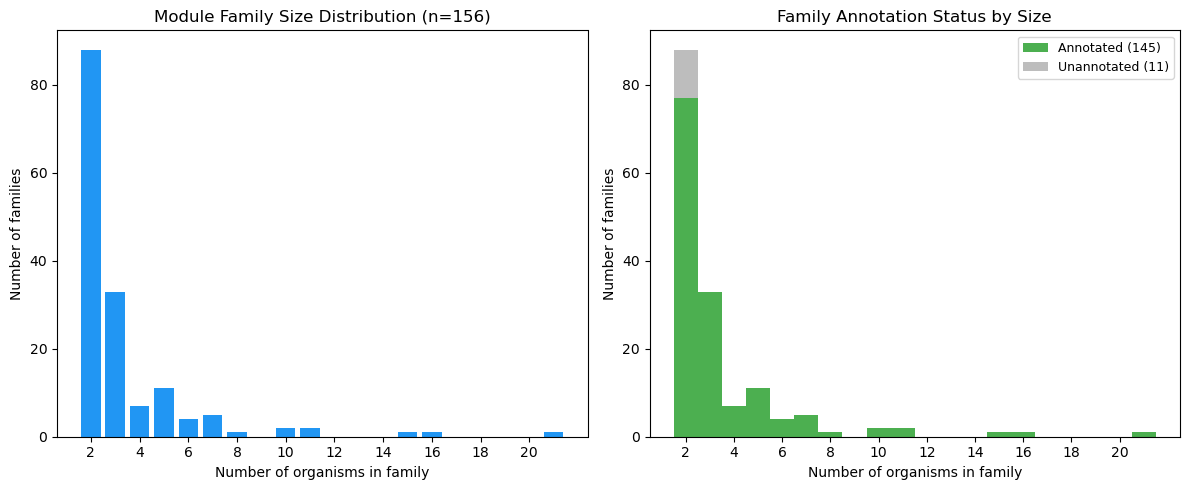

Families spanning 5+ organisms: 28
Families spanning 10+ organisms: 7
Largest family: 21 organisms
Saved: figures/module_families.png


In [7]:
import matplotlib.pyplot as plt

FIG_DIR = Path('../figures')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Family size distribution (number of organisms per family)
ax = axes[0]
fam_sizes = fam_ann_df['n_organisms'].value_counts().sort_index()
ax.bar(fam_sizes.index, fam_sizes.values, color='#2196F3')
ax.set_xlabel('Number of organisms in family')
ax.set_ylabel('Number of families')
ax.set_title(f'Module Family Size Distribution (n={len(fam_ann_df)})')
ax.set_xticks(range(2, fam_sizes.index.max() + 1, 2))

# Right: Annotated vs unannotated families by size
ax = axes[1]
annotated = fam_ann_df[fam_ann_df['consensus_term'] != 'unannotated']
unannotated = fam_ann_df[fam_ann_df['consensus_term'] == 'unannotated']
bins = range(2, fam_ann_df['n_organisms'].max() + 2)
ax.hist([annotated['n_organisms'], unannotated['n_organisms']], bins=bins,
        label=[f'Annotated ({len(annotated)})', f'Unannotated ({len(unannotated)})'],
        color=['#4CAF50', '#BDBDBD'], stacked=True, align='left')
ax.set_xlabel('Number of organisms in family')
ax.set_ylabel('Number of families')
ax.set_title('Family Annotation Status by Size')
ax.legend(fontsize=9)
ax.set_xticks(range(2, fam_ann_df['n_organisms'].max() + 1, 2))

plt.tight_layout()
plt.savefig(FIG_DIR / 'module_families.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Families spanning 5+ organisms: {(fam_ann_df['n_organisms'] >= 5).sum()}")
print(f"Families spanning 10+ organisms: {(fam_ann_df['n_organisms'] >= 10).sum()}")
print(f"Largest family: {fam_ann_df['n_organisms'].max()} organisms")
print(f"Saved: figures/module_families.png")